### 

## Generation of Systematics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Defining the fonts before plotting:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "monospace",  # Use monospace font
    "text.latex.preamble": r"\usepackage{courier}"  # Use Courier font
})
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    'font.family': 'monospace',  # monospace font
    "text.latex.preamble": r"\usepackage{courier}",
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})

### Sampling of a truncated Gaussian function

First, we need a way to calculate the error function. We use the aproximation (to provent using scipy):

In [2]:
# Approximation of the error function

def erf(x):
    x0 = np.abs(x)
    sign = np.sign(x)
    p = 0.3275911
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    t = 1.0 / (1.0 + p * x0)
    return (1.0 - ((a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5) * np.exp(-x0**2)))*sign

## From Abramowitz & Stegun (1964), formula 7.1.26, Handbook of Mathematical Functions: with Formulas, Graphs, and Mathematical Tables

Now, for a Gaussian distribution defines on some finite interval it is neccesary to add some normalization. The most compact way to write this defines the parameters:
$$
\xi = \frac{x - \mu}{\sigma}, \; \alpha = \frac{a - \mu}{\sigma}, \; \beta = \frac{b - \mu}{\sigma}.
$$
and the functions:
$$
\varphi(\xi) = \frac{1}{\sqrt{2\pi}} \exp \left(- \frac{1}{2} \xi^2 \right)
$$
and
$$
\Phi(x) = \frac{1}{2} \left(1 + \text{erf}(x/\sqrt{2}) \right)
$$
From where the PDF and CDF of the truncated gaussian are written respectively as:
$$
f(x, \mu, \sigma, a, b) = \frac{1}{\sigma} \frac{\varphi \left( \xi \right)}{\Phi \left( \beta \right) - \Phi \left( \alpha \right)}
$$
and 
$$
F(x, \mu, \sigma, a, b) = \frac{\Phi \left( \xi \right) - \Phi \left( \alpha \right)}{\Phi \left( \beta \right) - \Phi \left( \alpha \right)}
$$

In [3]:
### Truncated Gaussian distribution

# The limits for the distribution are:

xmin = 60
xmax = 160

# The CDF of a gaussian distribution:

def GCDF(x):
    return 1/2 * (1 + erf(x/np.sqrt(2))) 

# The PDF and CDF of the truncated gaussian distribution: 

def TruncatedGaussianPDF(x, mu, sigma, xmin, xmax):
    xi = (x - mu) / sigma
    alpha = (xmin - mu) / sigma
    beta = (xmax - mu) / sigma
    Z = GCDF(beta) - GCDF(alpha)
    return np.exp(-xi**2/2) / (sigma * np.sqrt(2 * np.pi) * Z)

def TruncatedGaussianCDF(x, mu, sigma, xmin, xmax):
    xi = (x - mu) / sigma
    alpha = (xmin - mu) / sigma
    beta = (xmax - mu) / sigma
    Z = GCDF(beta) - GCDF(alpha)
    return (GCDF(xi) - GCDF(alpha)) / Z    

Now, to get random samples from this distribution we generate random numbers between $0$ and $1$ and calculate the inverse of the CDF for the given values. This method (that was covered in the lectures) will then provide a random sample of values following the desired distribution. We calculate the inverse of the CDF numerically:

In [4]:
# A function to sample from the truncated gaussian distribution using the inverse transform sampling method:

def SamplingTruncatedGaussian(mu, sigma, xmin, xmax, size = 1000, steps=0.01):
    i = 0
    sample = np.array([])
    while i < size:
        rand1 = np.random.uniform(0, 1)
        temp = TruncatedGaussianCDF(np.arange(xmin, xmax, steps), mu, sigma, xmin, xmax) - rand1
        # We add the value in the interval [xmin, xmax] that minimizes the difference between the CDF and the random number
        sample = np.append(sample, np.arange(xmin, xmax, steps)[np.abs(temp).argmin()]) 
        i += 1
    return sample

And with this function we can generate our desired data:

In [5]:
samplesize = 10000

sample1 = SamplingTruncatedGaussian(91.2, 15, xmin, xmax, size=samplesize, steps=0.005)
sample2 = SamplingTruncatedGaussian(125, 17, xmin, xmax, size=samplesize, steps=0.005)

The distributions have been generated with 10000 data points. However, we are interested in giving a proportion of 500:30 to the Background and Signal counts, respectively. For this, we use the weights parameter in numpy histograms. We do this independently for the background, the signal, both simultaneously and their sum:

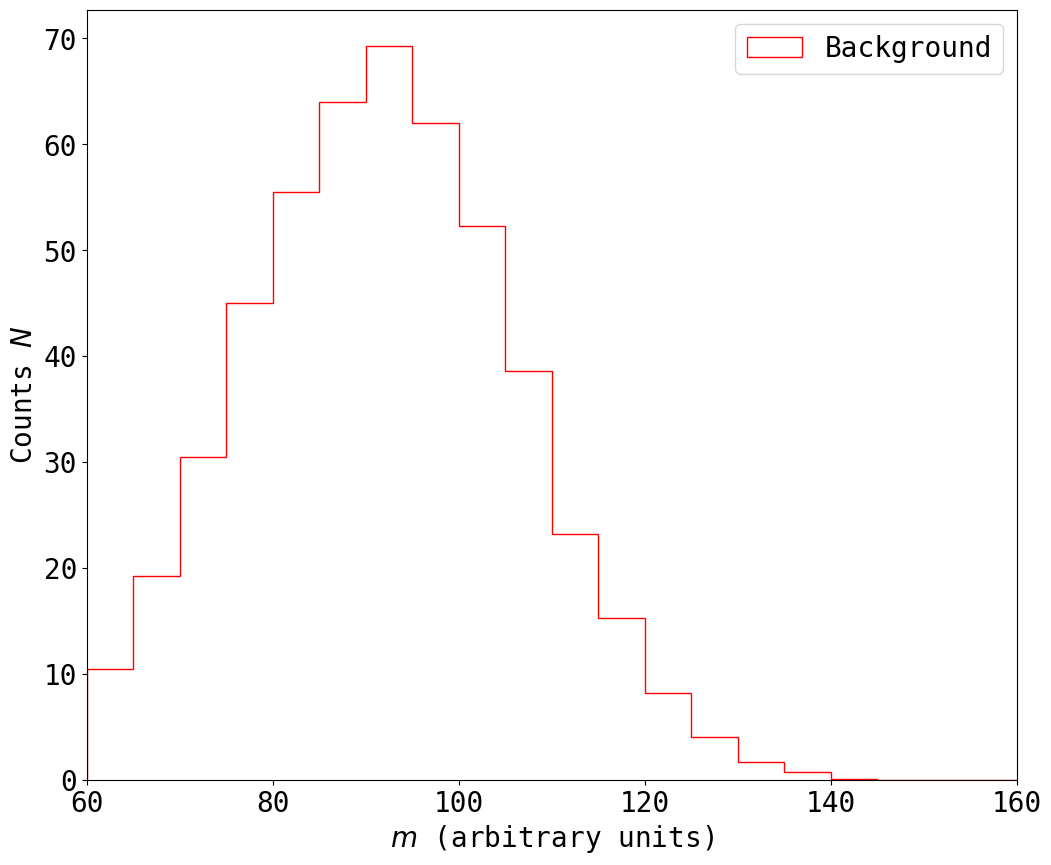

In [6]:
# Defining bin edges for a histogram with 20 equidistant bins between 60 and 160
bins = np.linspace(60, 160, 21)

plt.figure(figsize=(12, 10))
plt.xlim(60, 160)
counts1 = np.histogram(sample1, bins=bins)[0]
plt.hist(bins[:-1], bins=bins, density=False, weights=500/10000*counts1, edgecolor='red', histtype='step', label='Background')
plt.legend()
plt.xlabel(r"$m$ (arbitrary units)")
plt.ylabel(r"Counts $N$")
plt.savefig("plots/Background.pdf", bbox_inches='tight')
plt.show()

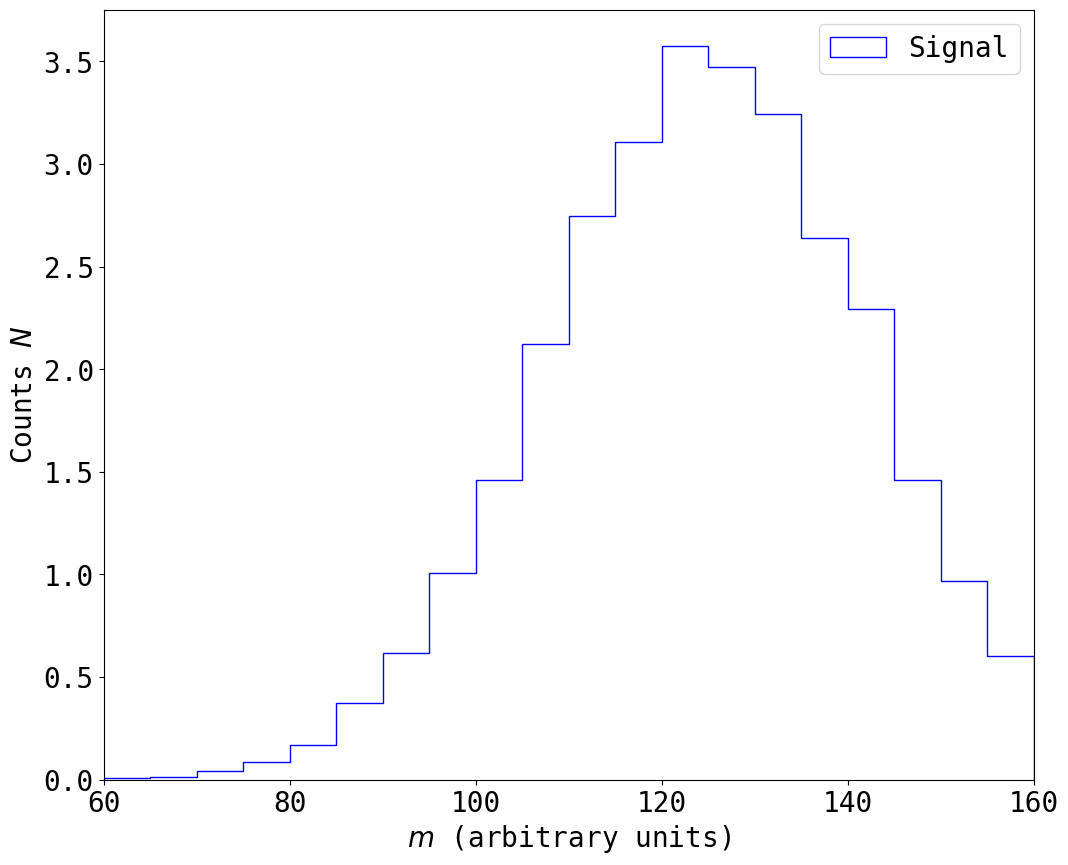

In [7]:
plt.figure(figsize=(12, 10))
counts2 = np.histogram(sample2, bins=bins)[0]
plt.hist(bins[:-1], bins, density=False, weights=30/10000*counts2, edgecolor='blue', histtype='step', label='Signal')
plt.xlim(60, 160)
plt.legend()
plt.xlabel(r"$m$ (arbitrary units)")
plt.ylabel(r"Counts $N$")
plt.savefig("plots/Signal.pdf", bbox_inches='tight')
plt.show()

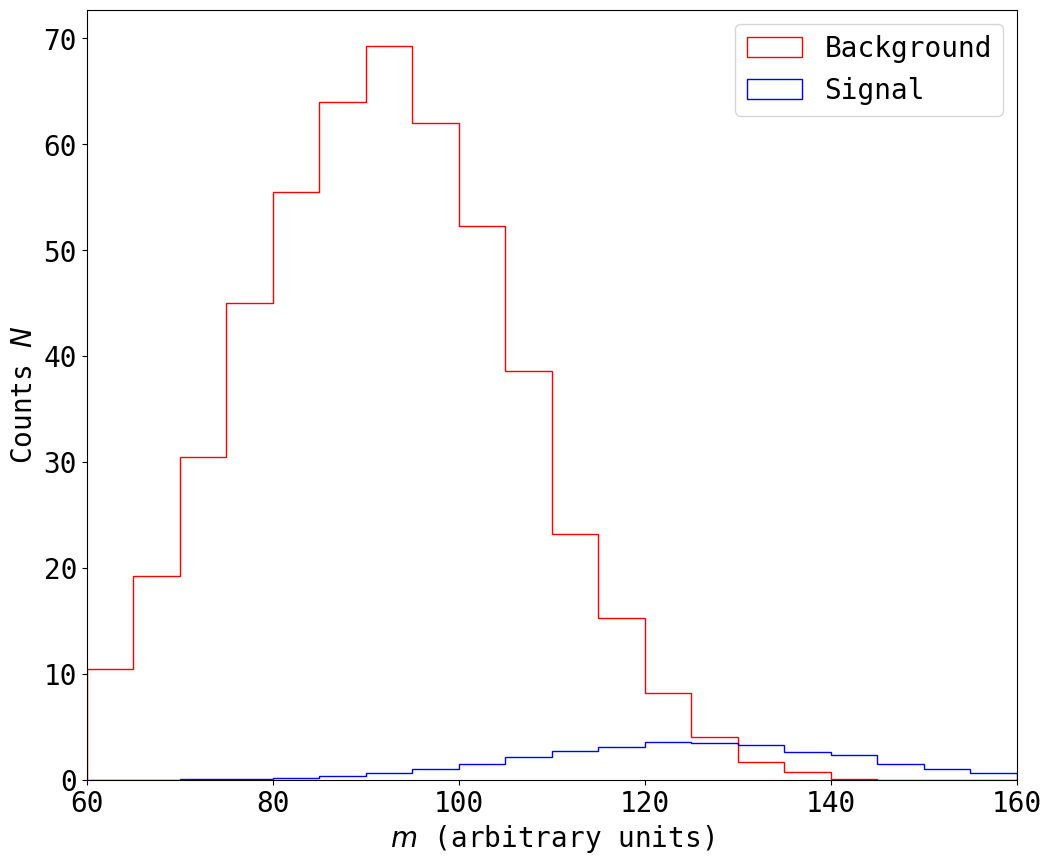

In [8]:
plt.figure(figsize=(12, 10))
plt.hist(bins[:-1], bins=bins, density=False, weights=500/10000*counts1, edgecolor='red', histtype='step', label='Background')
plt.hist(bins[:-1], bins=bins, density=False, weights=30/10000*counts2, edgecolor='blue', histtype='step', label='Signal')
plt.xlim(60, 160)
plt.legend()
plt.xlabel(r"$m$ (arbitrary units)")
plt.ylabel(r"Counts $N$")
plt.savefig("plots/Back_and_Signal.pdf", bbox_inches='tight')
plt.show()

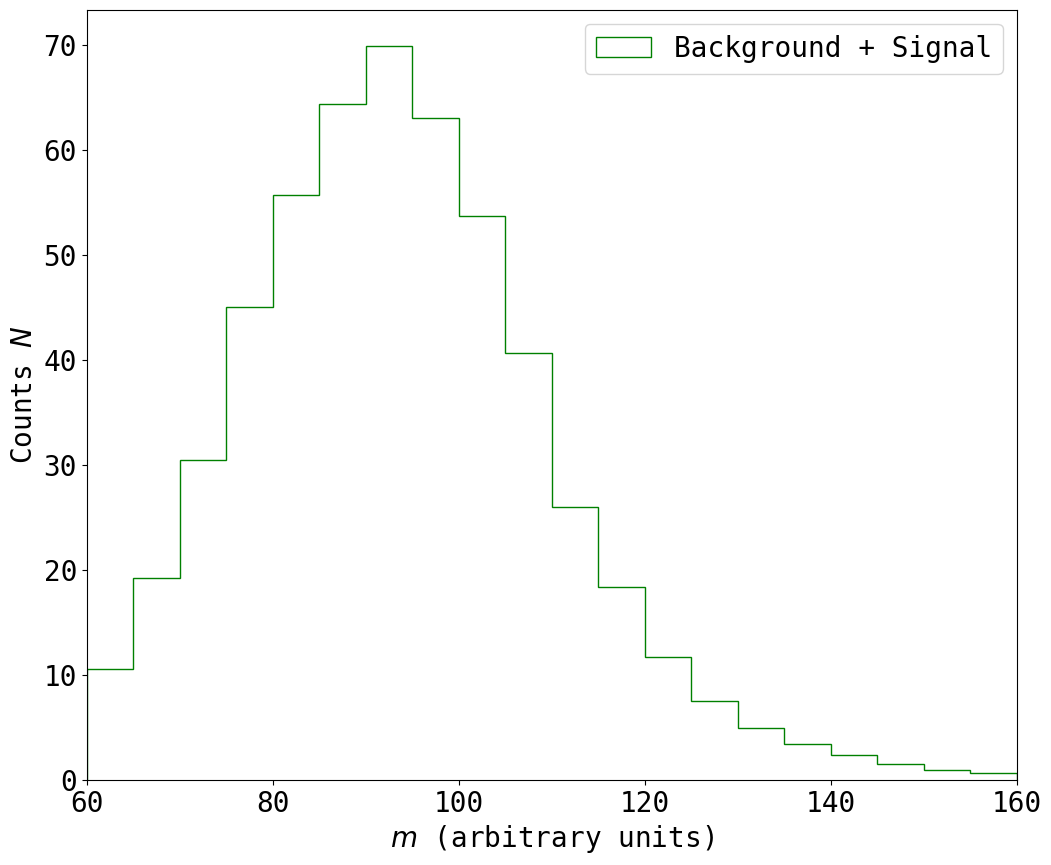

In [9]:
weights_sum = 500/samplesize *counts1 + 30/samplesize*counts2

plt.figure(figsize=(12, 10))
plt.hist(bins[:-1], bins=bins, density=False, weights=weights_sum, edgecolor='green', histtype='step', label='Background + Signal')
plt.xlim(60, 160)
plt.legend()
plt.xlabel(r"$m$ (arbitrary units)")
plt.ylabel(r"Counts $N$")
plt.savefig("plots/Back_plus_Signal.pdf", bbox_inches='tight')
plt.show()

### Variations for systematics:
We will generate the samplings beforehand to make manipulating the plots more convenient:

In [10]:
# Generating the systematic uncertainties that require a new samplings:

# Systematic 1: Variation of the variance of the distributions.

sigmavar = 2

sampleSys111 = SamplingTruncatedGaussian(91.2, 15 + sigmavar, xmin, xmax, size=samplesize, steps=0.005)
sampleSys121 = SamplingTruncatedGaussian(125, 17 + sigmavar, xmin, xmax, size=samplesize, steps=0.005)

sampleSys112 = SamplingTruncatedGaussian(91.2, 15 - sigmavar, xmin, xmax, size=samplesize, steps=0.005)
sampleSys122 = SamplingTruncatedGaussian(125, 17 - sigmavar, xmin, xmax, size=samplesize, steps=0.005)

# Systematic 2: Variation of the means of the distributions.

muvar = 10

sampleSys211 = SamplingTruncatedGaussian(91.2 + muvar, 15, xmin, xmax, size=samplesize, steps=0.005)
sampleSys221 = SamplingTruncatedGaussian(125 + muvar, 17, xmin, xmax, size=samplesize, steps=0.005)

sampleSys212 = SamplingTruncatedGaussian(91.2 - muvar, 15, xmin, xmax, size=samplesize, steps=0.005)
sampleSys222 = SamplingTruncatedGaussian(125 - muvar, 17, xmin, xmax, size=samplesize, steps=0.005)

### Systematic 1: Detector resolution

We get this by making the variance of the destributions higher:

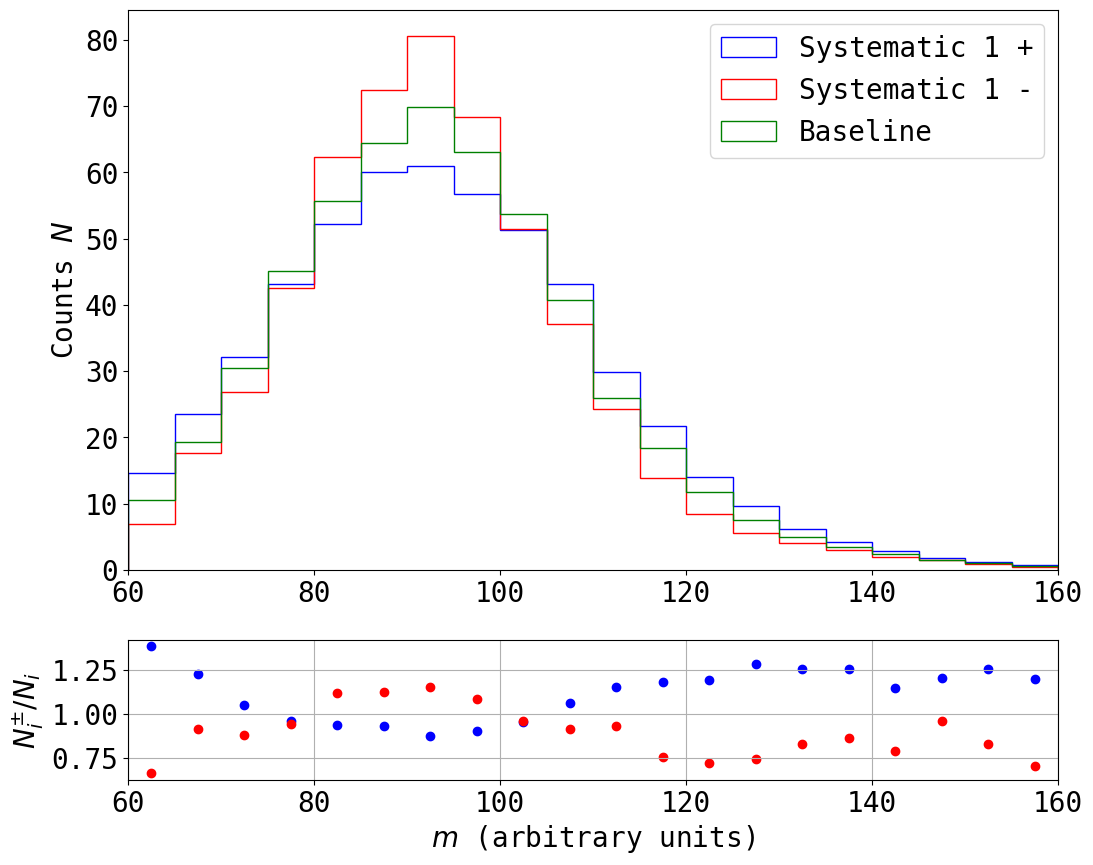

In [11]:
# Systematic 1: Variation of the variance of the distributions.

countsSys111 = np.histogram(sampleSys111, bins=bins)[0]
countsSys121 = np.histogram(sampleSys121, bins=bins)[0]
countsSys112 = np.histogram(sampleSys112, bins=bins)[0]
countsSys122 = np.histogram(sampleSys122, bins=bins)[0]

weights_sys1plus = 500/samplesize*countsSys111 + 30/samplesize*countsSys121
weights_sys1minus = 500/samplesize*countsSys112 + 30/samplesize*countsSys122


fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(12, 10), sharex=False)

ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sys1plus, edgecolor='blue', histtype='step', label='Systematic 1 +')
ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sys1minus, edgecolor='red', histtype='step', label='Systematic 1 -')
ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sum, edgecolor='green', histtype='step', label='Baseline')
ax[0].set_xlim(60, 160)
ax[1].set_xlim(60, 160)
ax[0].legend()

ax[1].scatter(bins[:-1] + (bins[1]-bins[0])/2, weights_sys1plus / weights_sum, color='blue')
ax[1].scatter(bins[:-1] + (bins[1]-bins[0])/2, weights_sys1minus / weights_sum, color='red')


ax[1].set_xlim(60, 160)
ax[1].set_xlabel(r"$m$ (arbitrary units)")
ax[0].set_ylabel(r"Counts $N$")
ax[1].set_ylabel(r"$N^{\pm}_i / N_i$")

ax[1].grid()

plt.savefig("plots/Systematic_1.pdf", bbox_inches='tight')

plt.show()

### Systematic 2: Momemtum scale

We get this by displacing the distribution in $m$. We get this by modifying the means:

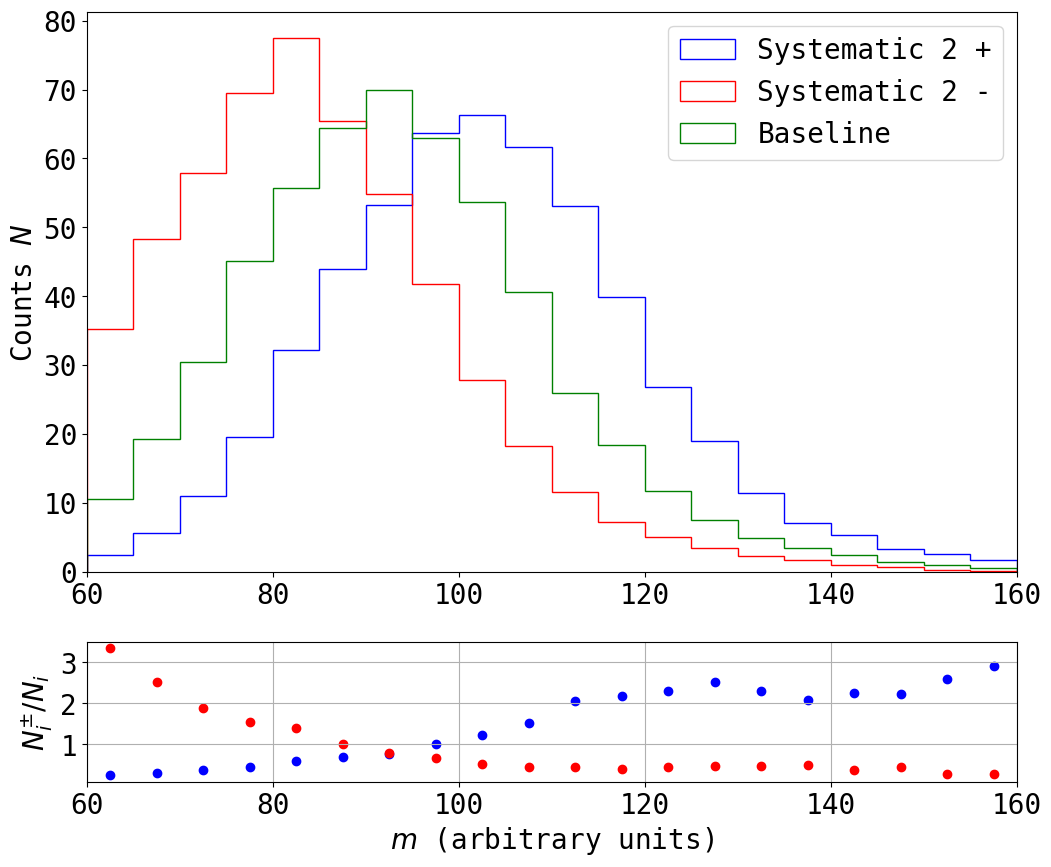

In [12]:
# Systematic 2: Variation of the means of the distributions.

countsSys211 = np.histogram(sampleSys211, bins=bins)[0]
countsSys221 = np.histogram(sampleSys221, bins=bins)[0]
countsSys212 = np.histogram(sampleSys212, bins=bins)[0]
countsSys222 = np.histogram(sampleSys222, bins=bins)[0]

weights_sys2plus = 500/samplesize*countsSys211 + 30/samplesize*countsSys221
weights_sys2minus = 500/samplesize*countsSys212 + 30/samplesize*countsSys222

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(12, 10), sharex=False)


ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sys2plus, edgecolor='blue', histtype='step', label='Systematic 2 +')
ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sys2minus, edgecolor='red', histtype='step', label='Systematic 2 -')
ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sum, edgecolor='green', histtype='step', label='Baseline')

ax[0].set_xlim(60, 160)
ax[0].legend()

ax[1].scatter(bins[:-1] + (bins[1]-bins[0])/2, weights_sys2plus / weights_sum, color='blue')
ax[1].scatter(bins[:-1] + (bins[1]-bins[0])/2, weights_sys2minus / weights_sum, color='red')
ax[1].set_xlim(60, 160)
ax[1].set_xlabel(r"$m$ (arbitrary units)")
ax[0].set_ylabel(r"Counts $N$")
ax[1].set_ylabel(r"$N^{\pm}_i / N_i$")

ax[1].grid()

plt.savefig("plots/Systematic_2.pdf", bbox_inches='tight')


plt.show()

### Systematic 3: Detector efficiency

Scaling the data accounts for detector efficiency:

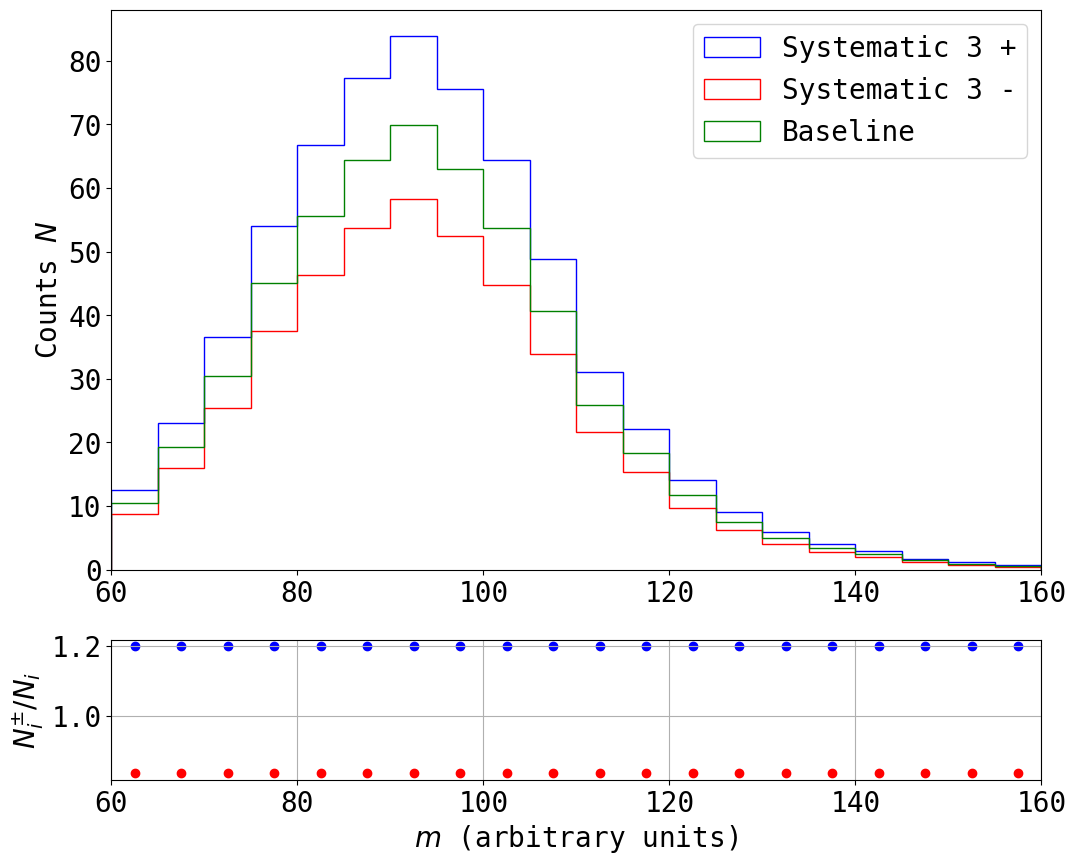

In [13]:
# Systematic 3: Adding a factor to the counts.

count_scale = 1.2
weights_sys3plus = count_scale * weights_sum
weights_sys3minus = weights_sum / count_scale

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(12, 10), sharex=False)


ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sys3plus, edgecolor='blue', histtype='step', label='Systematic 3 +')
ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sys3minus, edgecolor='red', histtype='step', label='Systematic 3 -')
ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sum, edgecolor='green', histtype='step', label='Baseline')
ax[0].set_xlim(60, 160)
ax[0].legend()

ax[1].scatter(bins[:-1] + (bins[1]-bins[0])/2, weights_sys3plus / weights_sum, color='blue')
ax[1].scatter(bins[:-1] + (bins[1]-bins[0])/2, weights_sys3minus / weights_sum, color='red')
ax[1].set_xlabel(r"$m$ (arbitrary units)")
ax[0].set_ylabel(r"Counts $N$")
ax[1].set_ylabel(r"$N^{\pm}_i / N_i$")
ax[1].set_xlim(60, 160)
ax[1].grid()

plt.savefig("plots/Systematic_3.pdf", bbox_inches='tight')

plt.show()

### Systematic 4: Detector gain

An scaling factor that varies for each bin of the data can model gain effects inside a detector: (This is the one I am the least sure about)

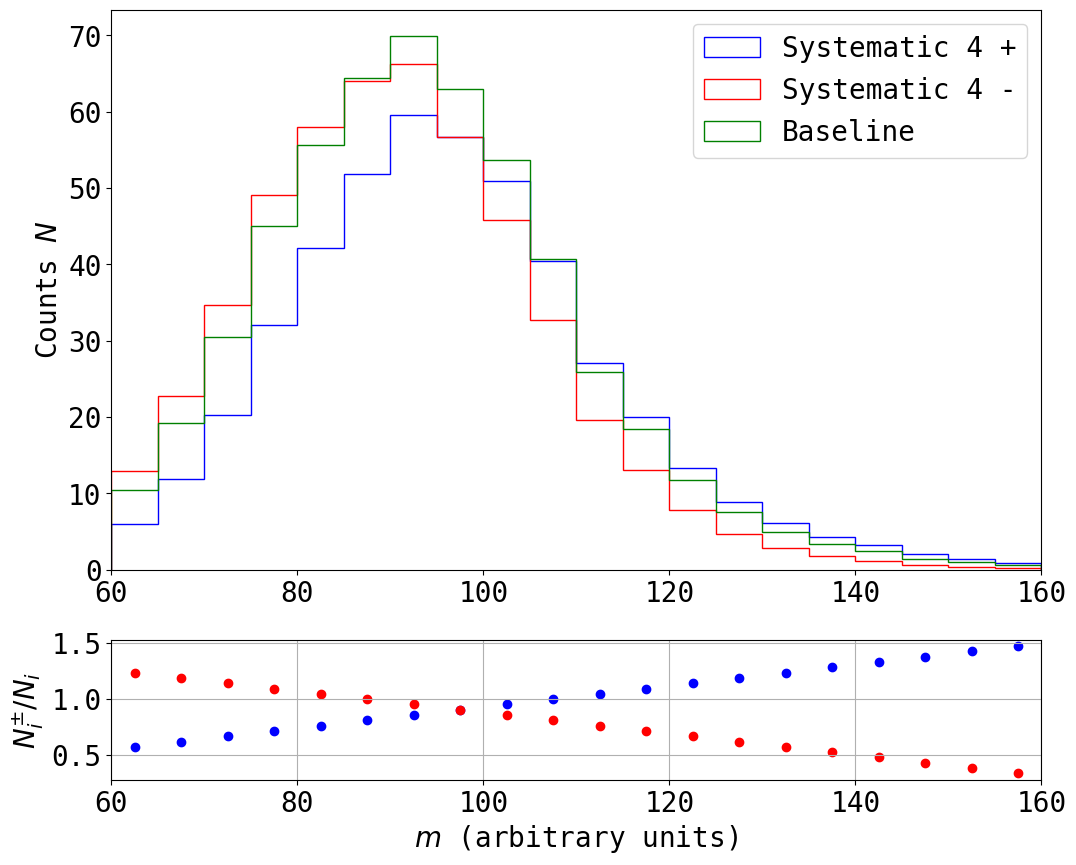

In [14]:
# Systematic 4: Assymetric factor that depends m, decreasing or increasing with m.

count_scale = 0.9*(1/(bins[-2] - bins[0])*bins[:-1]) 
invcount_scale = 0.9*(-1/(bins[-2] - bins[0])*bins[:-1]+2)

weights_sys4plus = count_scale*(500/samplesize*counts1 + 30/samplesize*counts2)
weights_sys4minus = invcount_scale*(500/samplesize*counts1 + 30/samplesize*counts2)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(12, 10), sharex=False)

ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sys4plus, edgecolor='blue', histtype='step', label='Systematic 4 +')
ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sys4minus, edgecolor='red', histtype='step', label='Systematic 4 -')
ax[0].hist(bins[:-1], bins=bins, density=False, weights=weights_sum, edgecolor='green', histtype='step', label='Baseline')
ax[0].set_xlim(60, 160)
ax[0].legend()

ax[1].scatter(bins[:-1] + (bins[1]-bins[0])/2, weights_sys4plus / weights_sum, color='blue')
ax[1].scatter(bins[:-1] + (bins[1]-bins[0])/2, weights_sys4minus / weights_sum, color='red')
ax[1].set_xlim(60, 160)
ax[1].set_xlabel(r"$m$ (arbitrary units)")
ax[0].set_ylabel(r"Counts $N$")
ax[1].set_ylabel(r"$N^{\pm}_i / N_i$")
ax[1].grid()

plt.savefig("plots/Systematic_4.pdf", bbox_inches='tight')

plt.show()

In [15]:
### The names for the weights of everything are: 

#bins

#weights_sum

#weights_sys1plus
#weights_sys1minus

#weights_sys2plus
#weights_sys2minus

#weights_sys3plus
#weights_sys3minus

#weights_sys4plus
#weights_sys4minus

pass